In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -Uqq fastai
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastai.vision.all import *

Mounted at /content/drive
     |████████████████████████████████| 194kB 18.2MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 


<strong><h2>Team:</h2></strong>
<h4>Ashish Bisht<br>Aakanksha Chauhan<br>Mardi Hach<br>Vaishnavi Narayanan<br>Adam Stegall</h4>

<br><br><br><br>

<strong><h2>Data: Panoramic Dental Radiographs</h2></strong>

<br>

<h4>The data was organized in 10 different categories:</h4>

<ul>
    <li><font style="font-size:16px">All teeth with restoration and with a dental appliance</font></li>
    <li><font style="font-size:16px">All teeth with restoration and without a dental appliance</font></li>
    <li><font style="font-size:16px">All teeth without restoration and with a dental appliance</font></li>
    <li><font style="font-size:16px">All teeth without restoration and without a dental appliance</font></li>
    <li><font style="font-size:16px">Contains dental implant</font></li>
    <li><font style="font-size:16px">More than 32 teeth</font></li>
    <li><font style="font-size:16px">Missing teeth with restoration and with dental appliance</font></li>
    <li><font style="font-size:16px">Missing teeth with restoration and without dental appliance</font></li>
    <li><font style="font-size:16px">Missing teeth without restoration and with dental appliance</font></li>
    <li><font style="font-size:16px">Missing teeth without restoration and without dental appliance</font></li>
</ul><br>

<h4>These categories were broken down into 6 different labels that will be used to classify the images.</h4>

<ol style="font-size:16px">
    <li>All teeth (32)</li>
    <li>Missing teeth (less than 32)</li>
    <li>Underwent dental restoration</li>
    <li>Contains dental appliance</li>
    <li>Contains dental implant</li>
    <li>More than 32 teeth</li>
</ol><br>

<h4>As you can see from the following dataframe, images can contain multiple labels.</h4>

In [2]:
path = '/content/drive/My Drive/images' # image path
df = pd.read_csv(path + '/train.csv') # load train labels to dataframe

In [3]:
df

,fname,labels
0,0000.jpg,1 3 4
1,0001.jpg,1 3 4
2,0002.jpg,1 3 4
3,0003.jpg,1 3 4
4,0004.jpg,1 3 4
...,...,...
295,0395.jpg,2
296,0396.jpg,2
297,0397.jpg,2
298,0398.jpg,2


In [4]:
df['labels'].unique()

array(['1 3 4', '1 3', '1 4', '1', '5', '6', '2 3 4', '2 3', '2 4', '2'],
      dtype=object)

<h4>By using the class <code>ImageDataLoaders</code>, we were able to create an object to hold our frames. We then utilized the argument <code>item_tfms=Resize()</code> to resize our images prior to training the model.</h4>

In [113]:
dls = ImageDataLoaders.from_df(df, path, folder='train', label_delim=' ', item_tfms=Resize(512), batch_tfms=aug_transforms(size=256), bs=32)

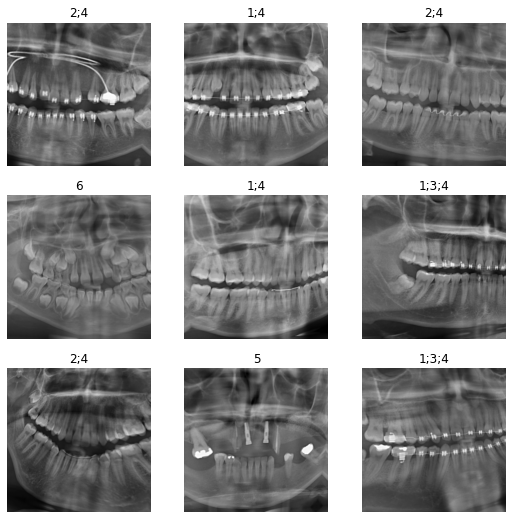

In [6]:
dls.show_batch() # displays images from the data object

<br>

<h4>Through an example runthrough, we used the same vision model for ours: <code>resnet50</code></h4>

In [7]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5)) # learner object used to train our model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


<h4>Here, we use the <code>lr_find()</code> method to determine a good learning rate for our model.</h4>

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.013182567432522774)

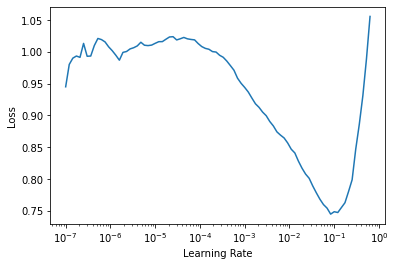

In [8]:
learn.lr_find() # finds the min and steepest learning rate

In [9]:
learn.fine_tune(4, 1e-2) # fine tune the learning rate

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.871250,1.185331,0.605556,00:23


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.720239,0.778479,0.666667,00:12
1,0.671912,0.612638,0.713889,00:12
2,0.620858,0.608225,0.733333,00:12
3,0.565917,0.576288,0.741667,00:12


<h4>The next cell simply displays random test frames from the model.</h4>

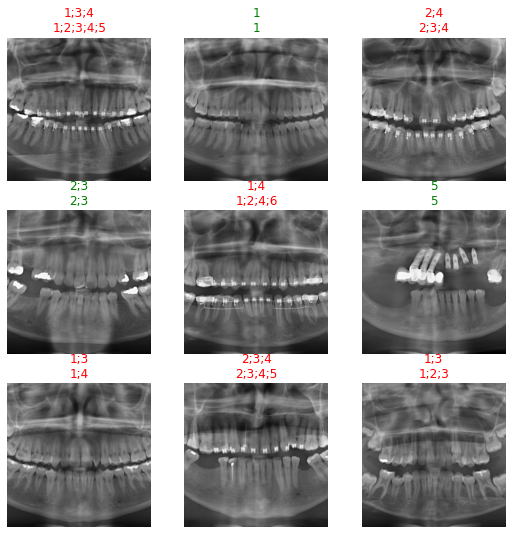

In [12]:
# display random frames from our model
# green text=correctly classified
# red text=incorrectly classified
learn.show_results(shuffle=True, max_n=9)

<h4>The frames with the highest lost are shown here.</h4>

,target,predicted,probabilities,loss
0,2;3,1;5,"tensor([0.6988, 0.0059, 0.3348, 0.0229, 0.9983, 0.3775])",2.3838448524475098
1,1;3;4,4;5;6,"tensor([0.0830, 0.2096, 0.0115, 0.9050, 0.9052, 0.9379])",2.070225954055786
2,2;4,1;4;5,"tensor([0.8872, 0.0880, 0.0523, 0.5691, 0.9058, 0.4046])",1.3518877029418945
3,2,1;3;5,"tensor([0.9054, 0.2953, 0.8907, 0.1045, 0.6652, 0.1178])",1.186782717704773
4,6,2;3;4;6,"tensor([0.1103, 0.9808, 0.7332, 0.7733, 0.0319, 0.9192])",1.1649667024612427
5,2,2;5;6,"tensor([3.7354e-02, 6.7729e-01, 4.5318e-04, 3.4528e-01, 9.9017e-01, 6.8828e-01])",1.106536626815796
6,1;4,2,"tensor([0.2498, 0.9254, 0.0814, 0.2058, 0.1403, 0.3840])",1.0473995208740234
7,2;3;4,1;3;4;5,"tensor([0.9303, 0.1618, 0.5276, 0.9895, 0.5988, 0.1316])",1.0316628217697144
8,2;4,1;4;6,"tensor([0.6928, 0.3342, 0.2958, 0.5463, 0.2866, 0.8932])",0.9676584601402283


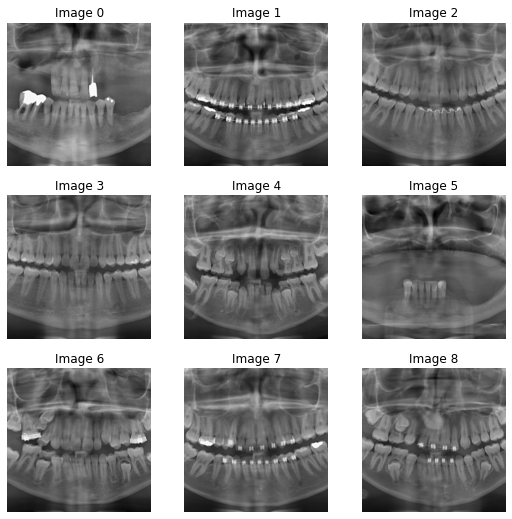

In [13]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9) # returns frames with the highest loss

<h4>We used a bash script to generate a list of frame numbers and labels. These frames were separated from the dataset used by our model. Here, we will use it to see how well our model performs on new data.</h4>

In [14]:
test_frames = pd.read_csv(path + '/test.csv') # load test labels to dataframe

In [15]:
test_frames

,fname,labels
0,0012.jpg,1 3 4
1,0017.jpg,1 3 4
2,0018.jpg,1 3 4
3,0020.jpg,1 3 4
4,0021.jpg,1 3 4
...,...,...
95,0378.jpg,2
96,0380.jpg,2
97,0391.jpg,2
98,0392.jpg,2


<h4>Simple script to test a <b>new</b> frame with our model.</h4>

In [85]:
def getPred(learner, *args):
    """Returns prediction for a specified or random test frame

    Args
    ------
      learner: learner object
      index: frame index; random by default

    Returns
    -------
      fname: string; name of frame
      label: string; frame label
      predict: tuple; calls predict method from learner object
        1. predicted label(s) for frame
        2. decoded prediction
        3. fully decoded prediction
    
    """
    if(len(args) > 0):
      idx = args[0]
      if(idx < 0 or idx > 99):
        return "Invalid index. Please enter an integer between 0 and 99."
    else:
      idx=np.random.randint(0, len(test_frames), dtype=int)

    fname = test_frames['fname'].iloc[idx]
    label = test_frames['labels'].iloc[idx]
    print("Frame: " + fname)
    print("Label: " + label + "\n")
    print("Prediction: ")
    return learner.predict(path + '/test/' + fname)

<h4>The information shown is the frame name <code>Fname</code>, the label for that frame <code>Label</code>, and the prediction made for it. The prediction results are formatted in 3 different ways. The first line provides the labels that were prediced. For this cell, the predicted labels were 2 and 6, however, the actual label was only 6. The second and third line are simply different representations of the prediction.</h4>

In [17]:
# predicts a frame from the test set
getPred(learn)

Frame: 0232.jpg
Label: 6

Prediction: 


((#2) ['2','6'],
 tensor([False,  True, False, False, False,  True]),
 tensor([0.4018, 0.9059, 0.0138, 0.0279, 0.1078, 0.9833]))

<br><br><br><br>

<strong><h2>Second Model</h2></strong>

<h4>Through some research, we have also learned that the vision model <code>densenet161</code> was also used frequently with multi-label classification problems.</h4>

In [112]:
# clear old learner to free up GPU memory
del learn
torch.cuda.empty_cache()

In [114]:
learn = cnn_learner(dls, densenet161, metrics=partial(accuracy_multi, thresh=0.5)) # learner object used to train our model

<h4>Unlike the first model, here we fine-tuned the model through repetition by repeating the next two code cells. We would call the <code>fine_tune()</code> method once and use the <code>lr_find()</code> method to help us determine a new learning rate. The model eventually converged around a learning rate of <code>9e-8</code>.</h4>

SuggestedLRs(lr_min=0.00043651582673192023, lr_steep=9.12010818865383e-07)

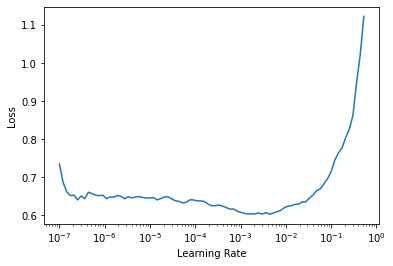

In [140]:
learn.lr_find() # finds the min and steepest learning rate

In [142]:
learn.fine_tune(0, 9e-8) # fine tune the learning rate

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.649958,0.583135,0.733333,00:14


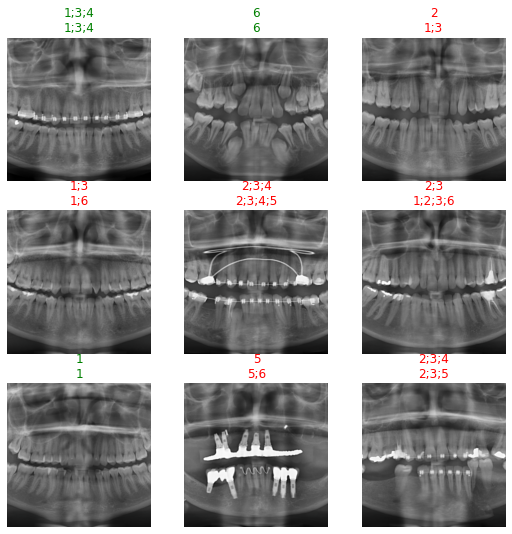

In [160]:
# display random frames from our model
# green text=correctly classified
# red text=incorrectly classified
learn.show_results(shuffle=True, max_n=9)

,target,predicted,probabilities,loss
0,2;4,1;3;6,"tensor([0.9069, 0.0296, 0.6004, 0.2452, 0.1872, 0.7107])",1.6107991933822632
1,2,1;5;6,"tensor([0.9707, 0.1193, 0.3588, 0.1954, 0.6142, 0.5800])",1.3564090728759766
2,2;4,1;3;4,"tensor([0.9746, 0.2055, 0.8151, 0.9994, 0.0347, 0.0661])",1.174808382987976
3,2,6,"tensor([0.3168, 0.1161, 0.1436, 0.3116, 0.1940, 0.9615])",1.0892114639282227
4,2;3,1;2;4;6,"tensor([0.8194, 0.7644, 0.1697, 0.6792, 0.0706, 0.6795])",1.01687753200531
5,2;4,1;4;5;6,"tensor([0.7840, 0.1970, 0.2997, 0.9999, 0.6737, 0.7616])",1.011185884475708
6,5,2;3;5,"tensor([0.0045, 0.9823, 0.7365, 0.1716, 0.8895, 0.3103])",1.0085203647613525
7,2;3,1;2;3;6,"tensor([0.9569, 0.5716, 0.9642, 0.4302, 0.2205, 0.6525])",0.9349309206008911
8,1;4,6,"tensor([0.4750, 0.1105, 0.0822, 0.0440, 0.1709, 0.7093])",0.9155765771865845


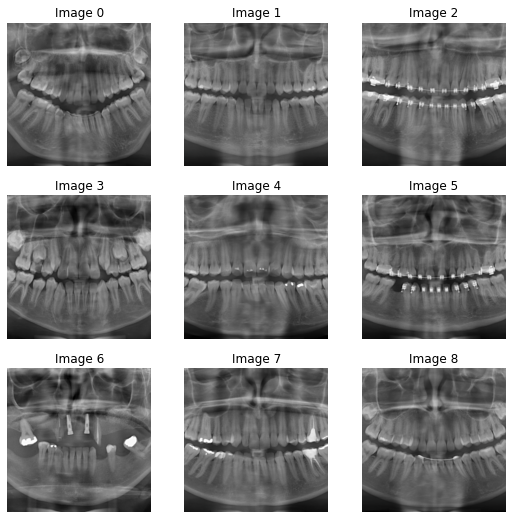

In [145]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9) # returns frames with the highest loss

In [168]:
getPred(learn, 99)

Frame: 0394.jpg
Label: 2

Prediction: 


((#3) ['1','5','6'],
 tensor([ True, False, False, False,  True,  True]),
 tensor([0.5006, 0.0236, 0.0386, 0.0558, 0.5568, 0.9536]))